In [1]:
import sys

import jax.numpy as np
import optax
from jax import jit, vmap

from base_network import neural_network
from plotutils import plot_losses, plot_poisson
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory
from utils import data_path
from xpinn import XPINN

In [2]:
# Set files
name = str(sys.argv[1])
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh

# Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [3]:
# Set true solution and RHS
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))


# rhs
@jit
def f(x):
    return 2.0 * np.pi**2 * u_star(x)

In [4]:
f_v = f
f_final = jit(f_v)
# Set losses
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(p0, 0)
p0.interior_loss = interior_loss_factory(p0, f_final)
p0.create_loss()
xpinn.set_loss()

In [5]:
# Initializing optimizer
shapes = [[2, 64, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=exponential_decay)

    pinn.init_params(shape, optimizer)

In [6]:
# Setting iterations
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 96.1642074584961
10.00% iter = 20000 of 200000: Total loss = 7.01913086231798e-05
20.00% iter = 40000 of 200000: Total loss = 3.182814543833956e-05
30.00% iter = 60000 of 200000: Total loss = 2.65041999227833e-05
40.00% iter = 80000 of 200000: Total loss = 2.54212263826048e-05
50.00% iter = 100000 of 200000: Total loss = 2.4448236217722297e-05
60.00% iter = 120000 of 200000: Total loss = 2.3554492145194672e-05
70.00% iter = 140000 of 200000: Total loss = 2.2714713850291446e-05
80.00% iter = 160000 of 200000: Total loss = 2.1917137928539887e-05
90.00% iter = 180000 of 200000: Total loss = 2.1163245037314482e-05
100.00% iter = 200000 of 200000: Total loss = 2.0452083845157176e-05


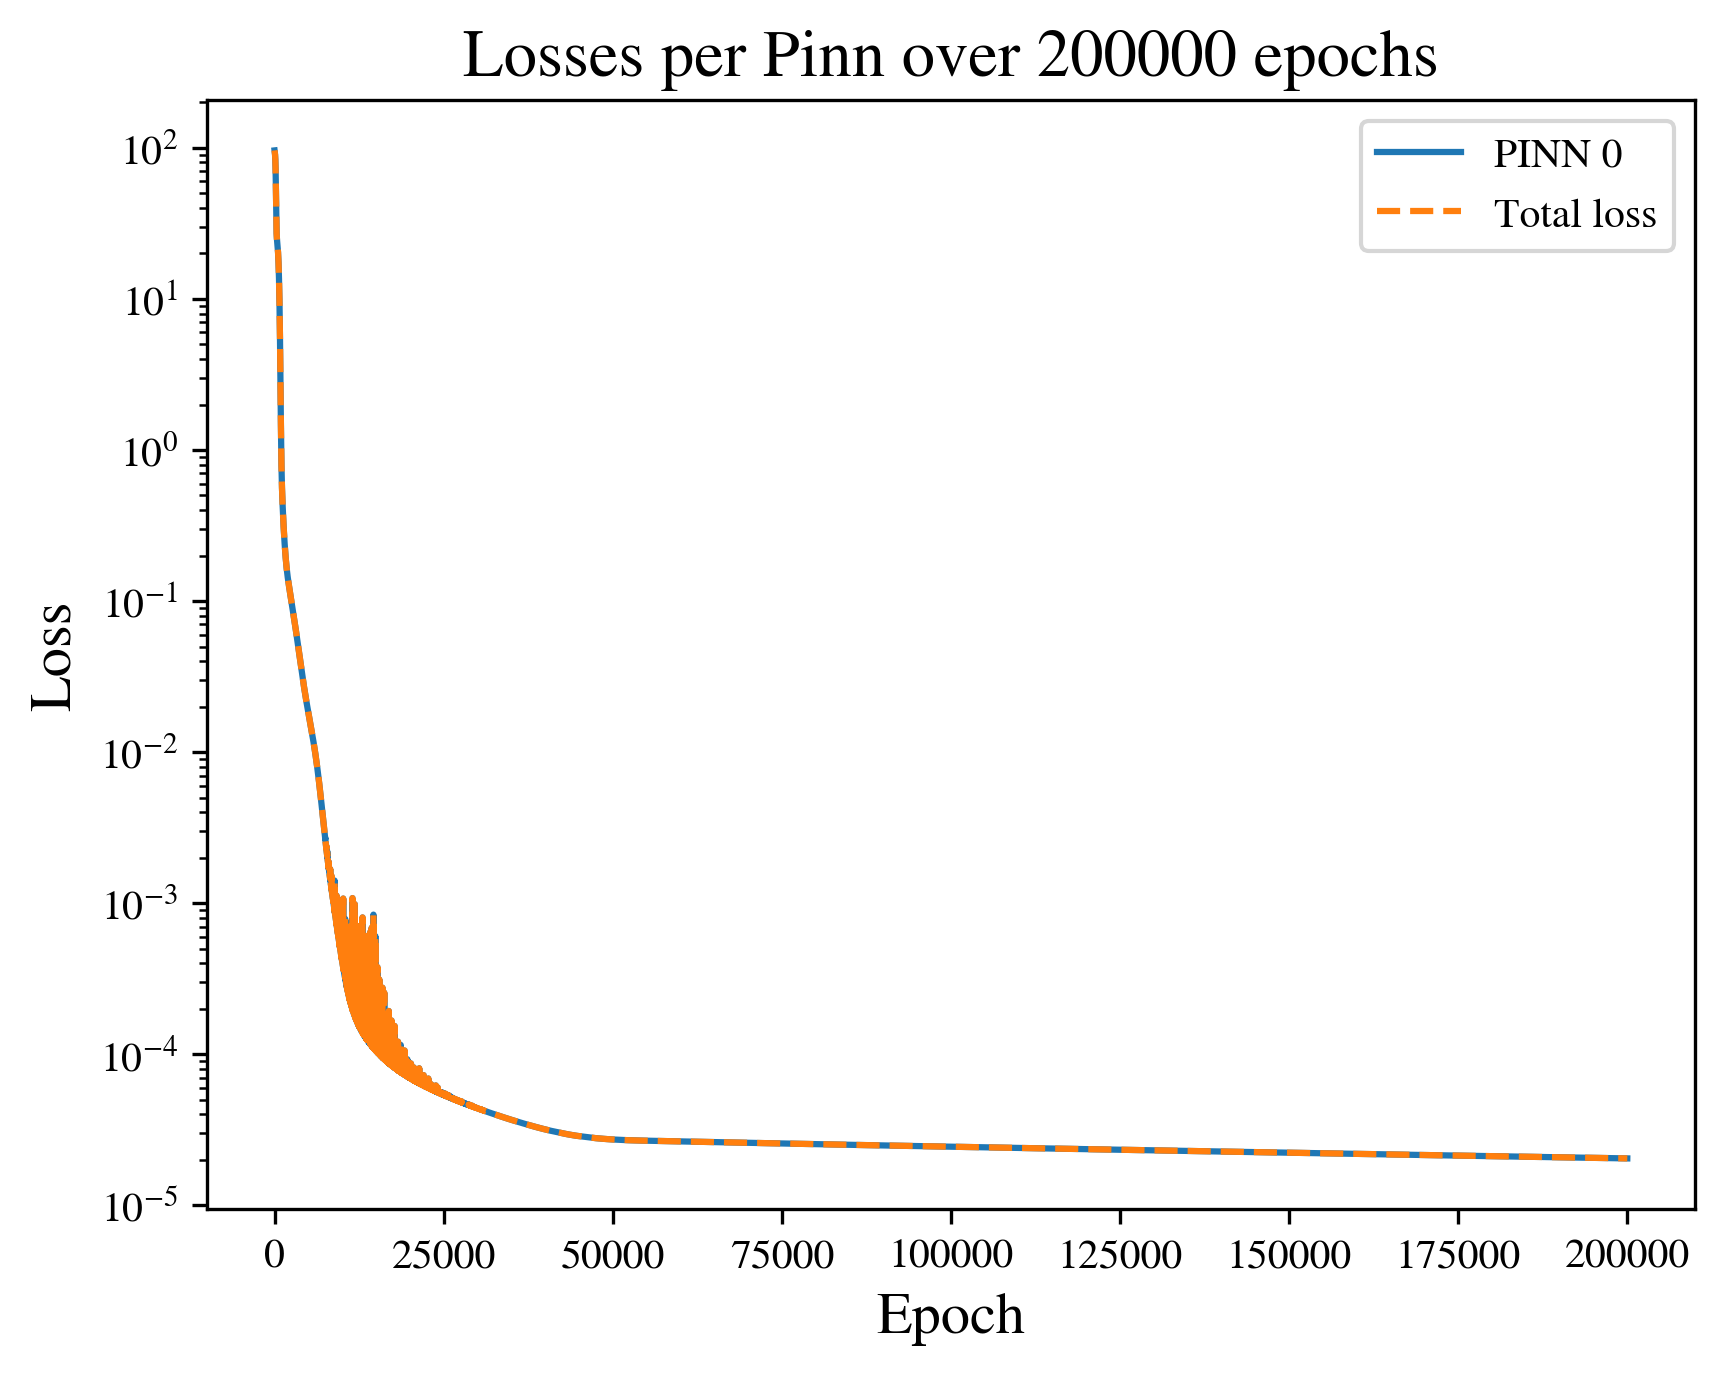

In [7]:
save_path = data_path.parent / "figures/Poisson"
plot_losses(
    losses,
    n_iter,
    title=f"Losses per Pinn over {n_iter} epochs",
    savepath=save_path,
    save_name="smooth_single_Poisson_losses",
)

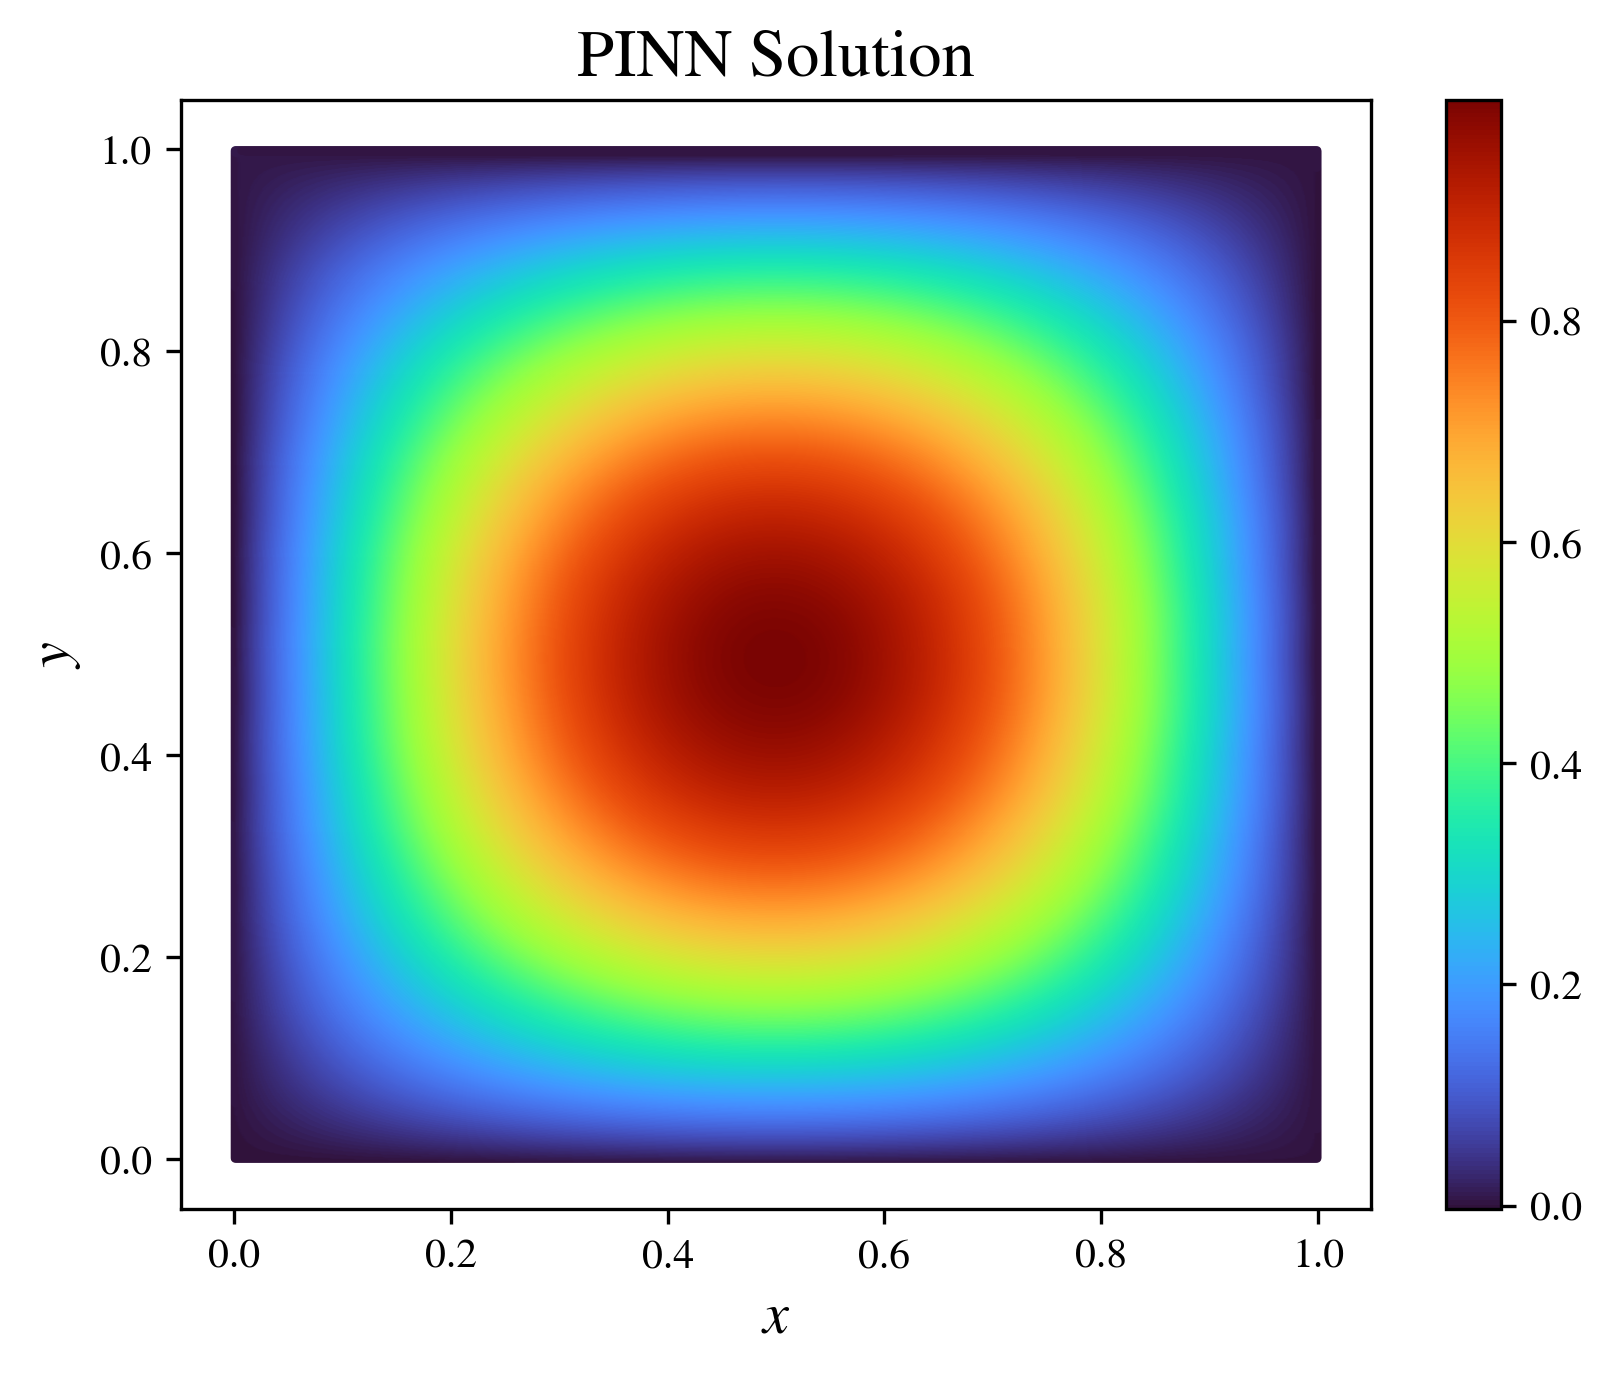

In [8]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)

plot_poisson(
    total_points,
    total_pred,
    savepath=save_path,
    save_name="smooth_single_Poisson_solution",
    title="PINN Solution",
)

In [9]:
u_vmap = vmap(u_star, (0))
true_value = u_vmap(total_points).reshape(-1, 1)

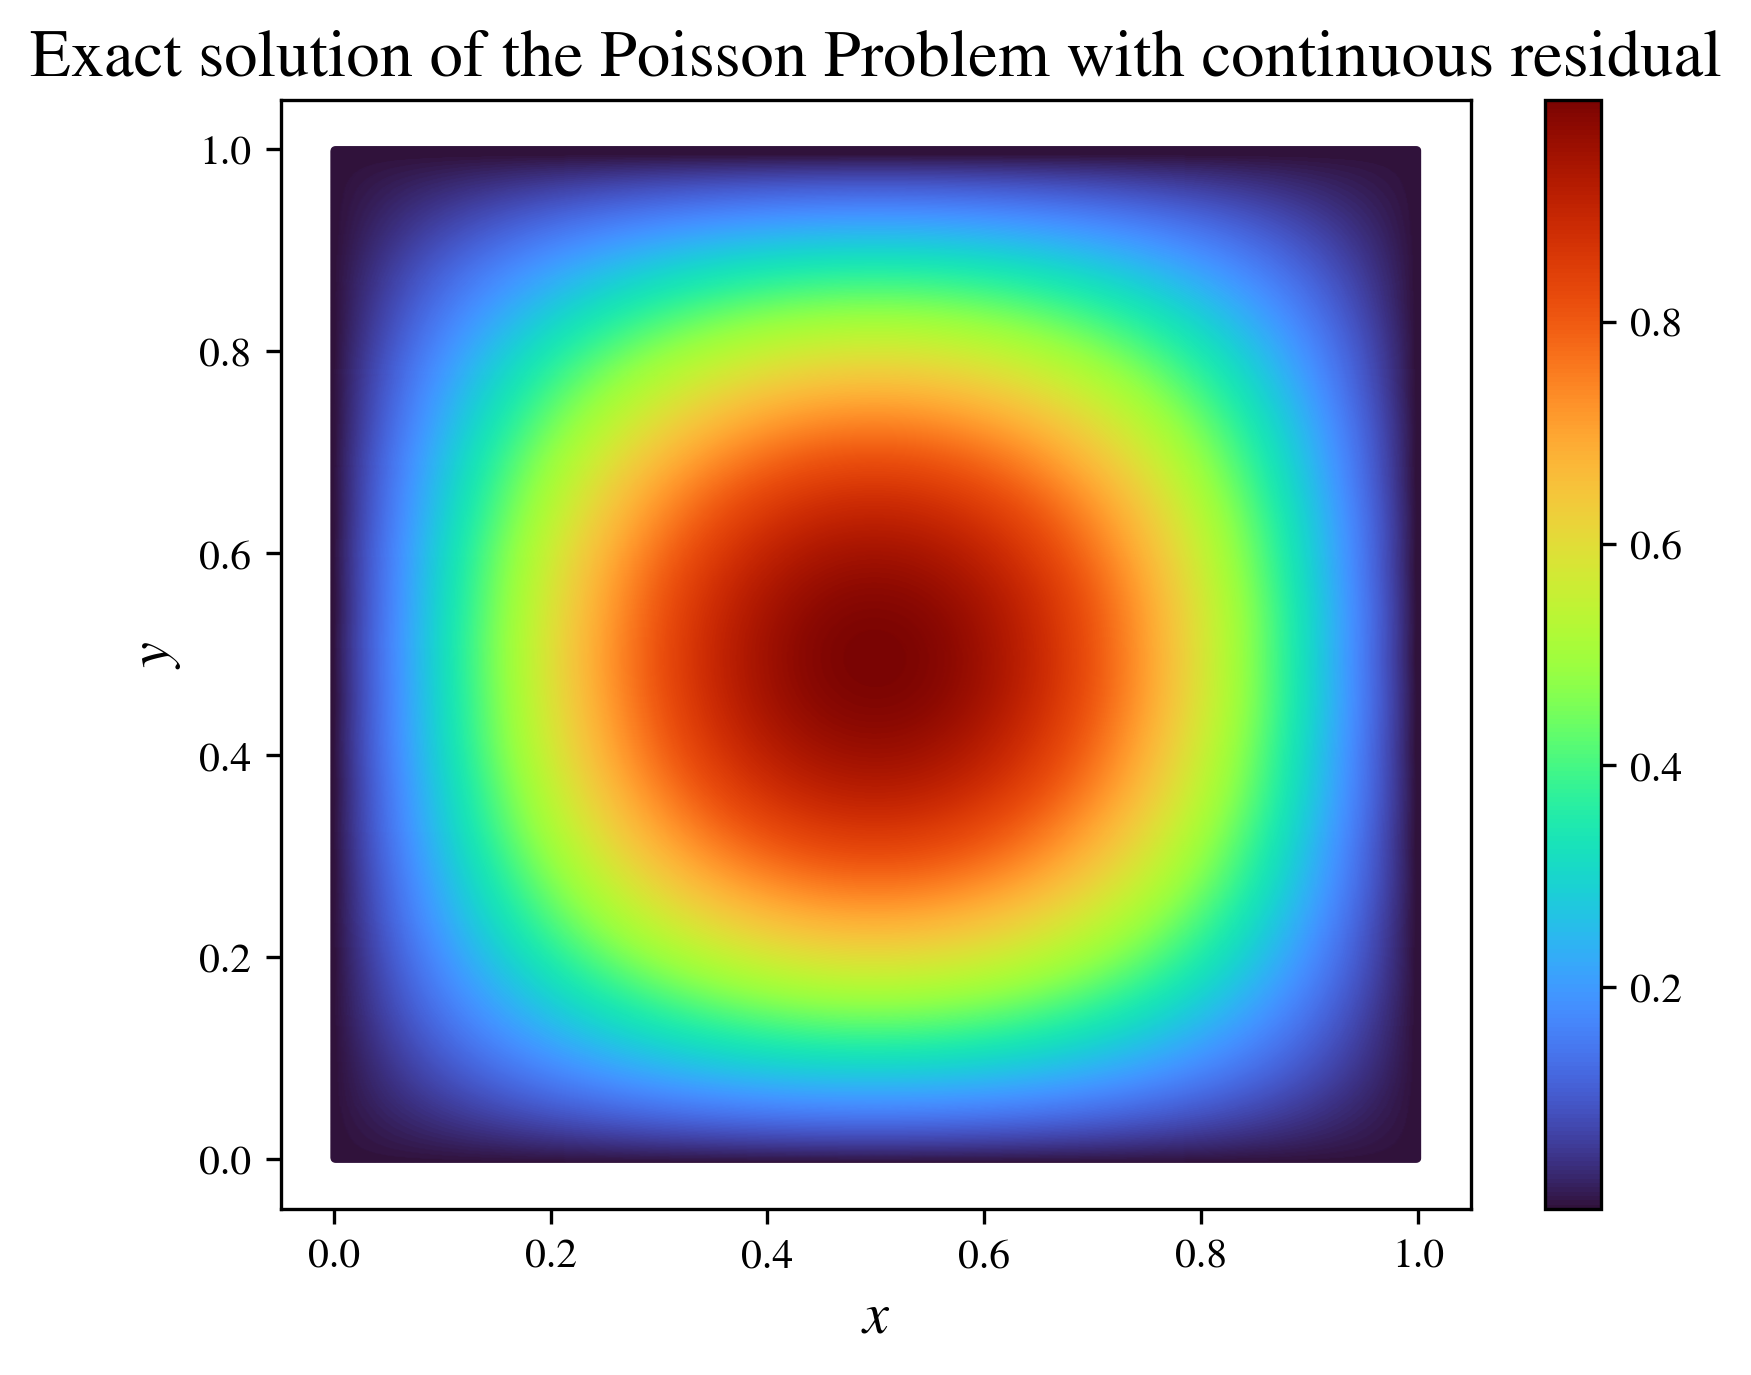

In [10]:
plot_poisson(
    total_points,
    true_value,
    savepath=save_path,
    save_name="smooth_Poisson_true",
    title="Exact solution of the Poisson Problem with continuous residual",
)

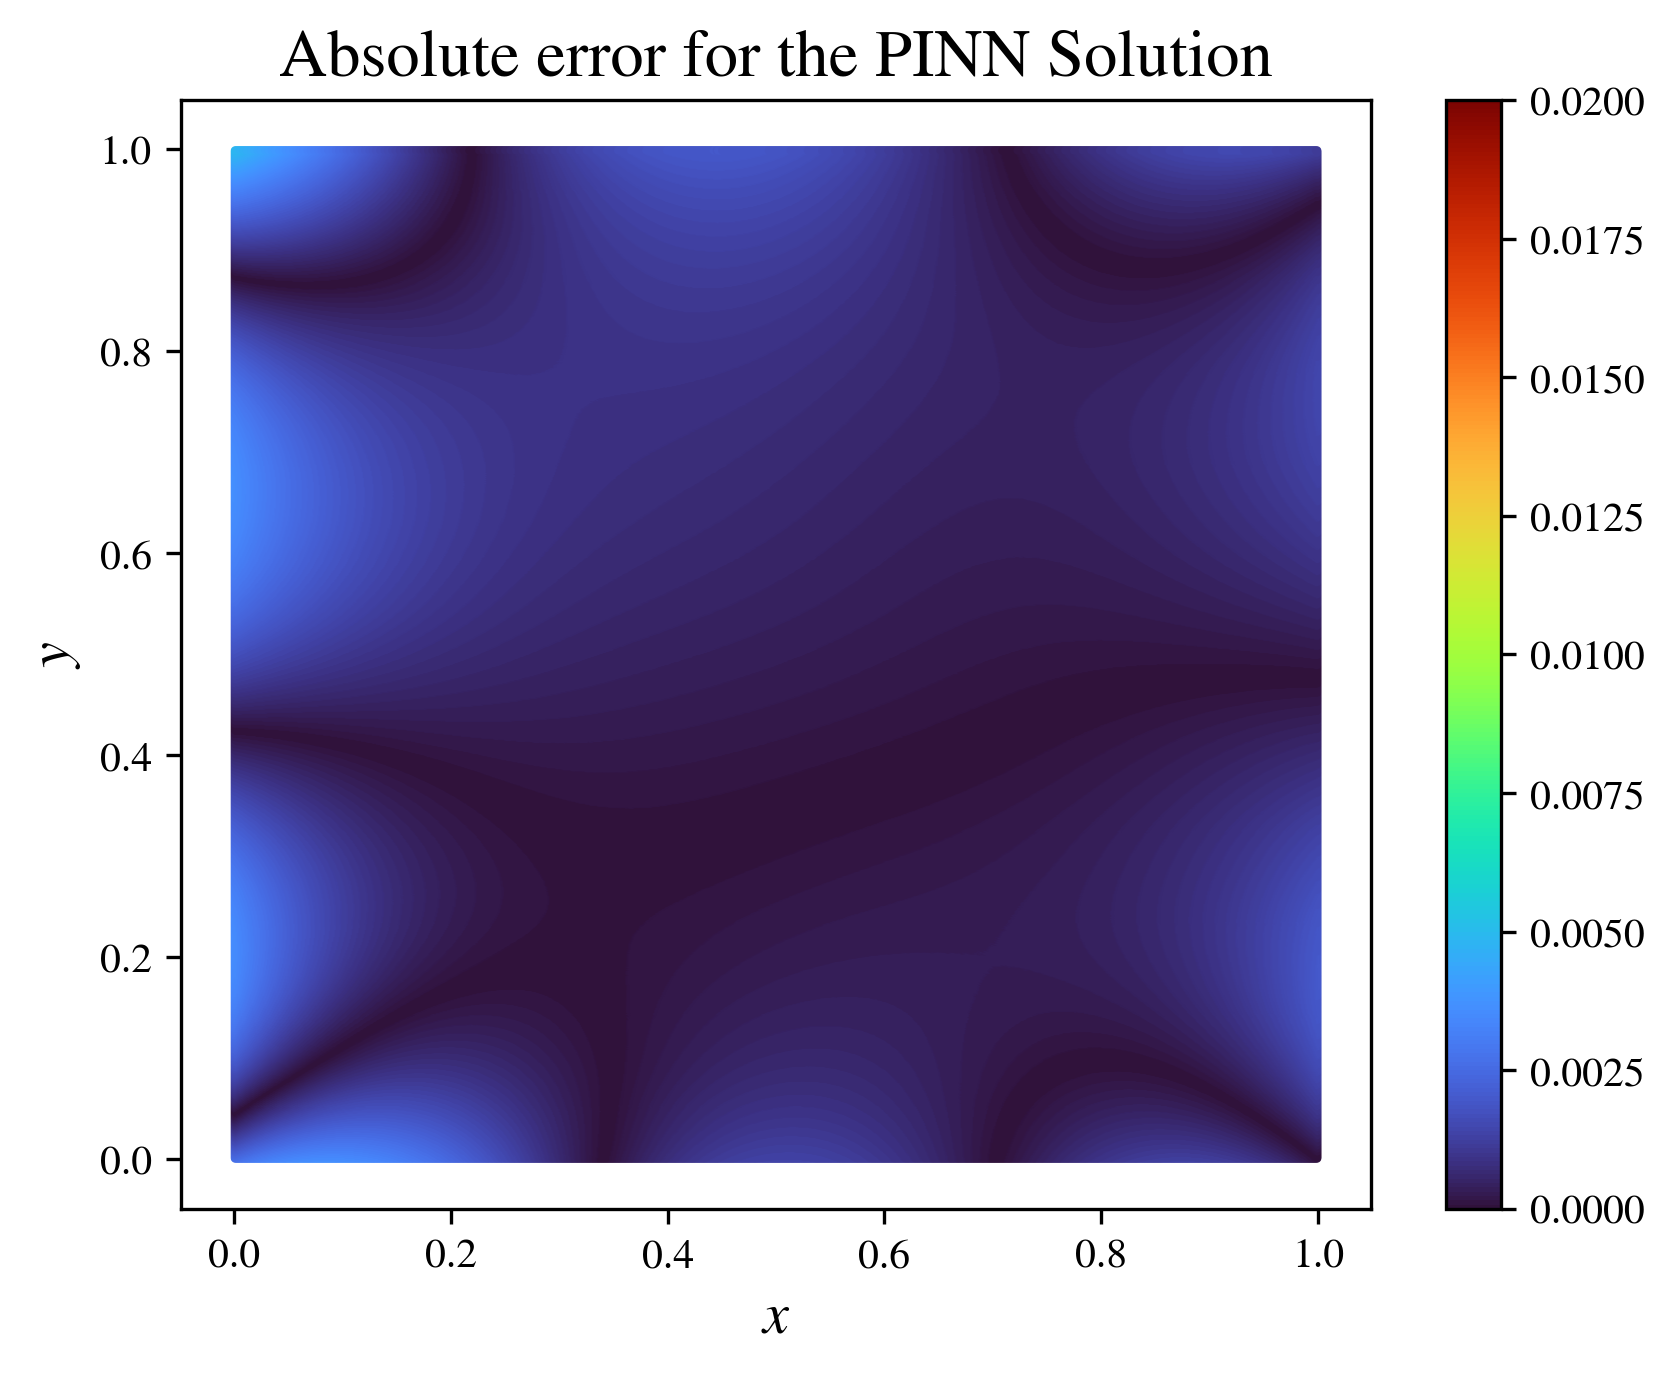

In [11]:
abs_pinn = np.abs(total_pred - true_value)

plot_poisson(
    total_points,
    abs_pinn,
    savepath=save_path,
    save_name="smooth_single_Poisson_error",
    title="Absolute error for the PINN Solution",
    clim=(0, 0.02),
)